# Data gathered from all BRCA patients
* All BRCA cancer samples were downloaded for TCGA resulting in expression profiles for 1102 patients
* Normal data was downloaded for 114 patients
    * For the 20532 genes median expression values were calculated.  These will function as baseline expression for the 1102 patients
* Fold change calculated for 1102 patients as log2(cancer exp/median normal exp) per 20532 genes.
* This allows for near complete overlap with protein data (106 patients, out of about 108)

# Normalizing protein and mRNA values with z-score

One thing that I want to do is make sure we equivalently scale the fold changes for protein and mRNA expression.  Since these two facets of data were normalized by separate means, the scaling may be impacted in such a fashion that ranges are not equivalent.

I will take the originally calculated, individual-level fold changes and apply a z-score standardization to it:

$$z = \frac{x – \mu}{\sigma}$$

This should normalize the scale of both so more accurate calculations can be made.  First we will observe the patient level, z-score normalized fold changes and plot them against each other.

In [2]:
%cd ../../../bioinfo/combined_attempt/output/

/mnt/bay1/bioinfo/combined_attempt/output


/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


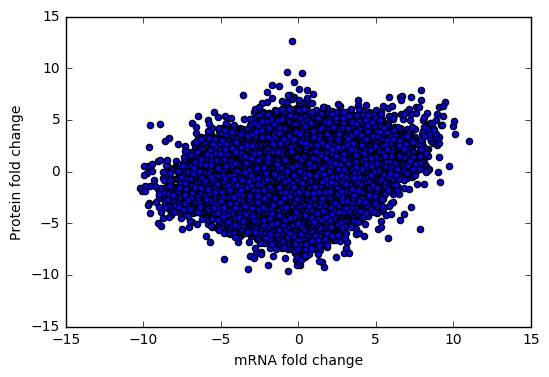

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# calculate z score as above:
# value minus the mean of the vector over the S.D.
def calculate_z(val,val_mean,val_sd):
    num   = val - val_mean
    denom = val_sd
    # make sure the denominator is not 0
    if denom != 0:
        return num/denom
    else:
        return np.nan
    
df           = pd.read_csv(open("../data/intermediate/merged_protein_mrna.txt",'r'),delimiter="\t")

# Calculate mean value and SD for mrna/protein
mean_prot = np.mean(df['prot'])
mean_mrna = np.mean(df['mrna'])
sd_prot   = np.std(df['prot'])
sd_mrna   = np.std(df['mrna'])

df['prot_z'] = df['prot'].apply(lambda x: calculate_z(x,mean_prot,sd_prot))
df['mrna_z'] = df['mrna'].apply(lambda x: calculate_z(x,mean_mrna,sd_mrna))

# plot the results
plt.scatter(df['mrna_z'],df['prot_z'])
plt.ylabel("Protein fold change")
plt.xlabel("mRNA fold change")
plt.show()

We can see the axes are consistent for both mRNA and protein.  This indicates a decent method of standardization between the two datasets.  The plot emphasizes the distribution and variability of mRNA and protein fold changes.  It also suggests that the fold change of one 'omics data source does not necessarily reflect that of the other.  

# CNV data and fold-change

To enhance our understanding of protein and mRNA expression changse, I am including Copy Number Variant (CNV) data.  This emphasizes regions of the genome that have amplification, duplication, or deletion events.  For example, if we observe a gene with high mRNA change, high protein change, and amplification on the genome, we can safely assume these changes are not due to a disruption of a regulatory network.  Instead, these genes may be cancer-causative.  

## Data gathering

CNV data was gathered from the NIH GDC (TCGA's new data warehouse).  Segment means were selected for 1095 BRCA patients.  These segments were mapped to hg38 gene regions from UCSC and collected into a single set.  Regions mapping to multiple genes were broken down to repetitive segment means for each gene.  For each sample, the maximum total copy number appproximation was selected. The segment means were adjusted to a total copy number estimate as follows :

$$CNV Number = 2*(2^{Segment mean})$$

CNV Data was then joined based on gene symbol and TCGA barcode using additional TCGA metadata files.

Chromosomal locations were parsed from gene annotation information to facilitate data browsing.

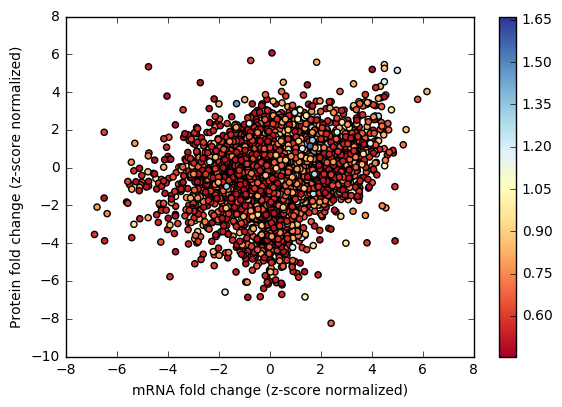

In [43]:
from matplotlib.ticker import NullFormatter
import matplotlib.pyplot as plt

# Location checking function change if statement for region of interest
def location_check(loc_string):
    if '20q' in loc_string:
        return 1
    else:
        return 0
import numpy as np
def check_amp(x):
    if x > 0.2:
        return "amplification"
    elif x < -0.2:
        return "deletion"
    else:
        return "neither"

# Read annotation data
gene_annotation = pd.read_csv(open("../data/staging/hgnc_complete_set.txt",'r'),delimiter="\t")
# Join with fold-change data
df2_annotated = pd.merge(gene_annotation[['symbol','location','location_sortable']],
                         df,left_on='symbol',right_on='Gene')
# Grab region of interest
df2_annotated['in_region'] = df2_annotated['location_sortable'].map(lambda x: (location_check(x)))

# Add and join cnv data
annotated_cnv = pd.read_csv(open("../data/intermediate/cnv_w_gene.txt",'r'),
                           sep="\t")
annotated_cnv['BARCODE']      = annotated_cnv['BARCODE'].map(lambda x: x.replace('TCGA-',''))

df2_w_cnv = pd.merge(df2_annotated,annotated_cnv,
                     left_on=["Sample","symbol"],right_on=["BARCODE","GENESYMBOL"],how='left')
df2_w_cnv['seg_mean']  = df2_w_cnv['TOTAL_COPY_NUMBER'].map(lambda x:  np.log2(float(x))/2)
df2_w_cnv['cnv_state'] = df2_w_cnv['seg_mean'].map(lambda x: check_amp(x))
df5 = df2_w_cnv[df2_w_cnv['in_region'] == 1].reset_index()

cm = plt.cm.get_cmap('RdYlBu')

#definitions for the axes
#nullfmt = NullFormatter()         # no labels
left, width = 0.2, 0.85
bottom, height = 0.2, 0.85
bottom_h = left_h = left + width + 0.04
rect_scatter = [left, bottom, width, height]
axScatter2 = plt.axes(rect_scatter)

binwidth = 0.25
xymax = np.max([np.max(np.fabs(df5['mrna_z'])), np.max(np.fabs(df5['prot_z']))])
lim = (int(xymax/binwidth) + 1) * binwidth

bins = np.arange(-lim, lim + binwidth, binwidth)


s = axScatter2.scatter(df5['mrna_z'],df5['prot_z'],c=df5['seg_mean'],cmap=cm)


axScatter2.set_xlabel("mRNA fold change (z-score normalized)")
axScatter2.set_ylabel("Protein fold change (z-score normalized)")

labels = list(df5['Gene'])
plt.colorbar(mappable=s,ax=axScatter2)
plt.show()

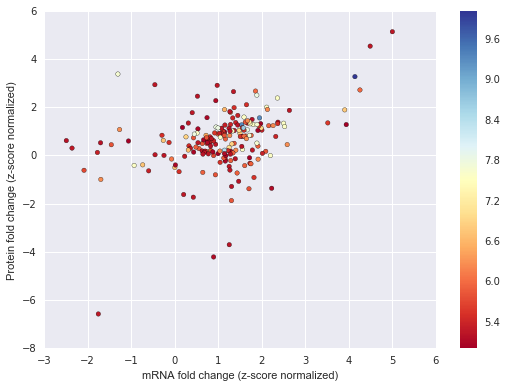

In [74]:
df6 = df5[df5['TOTAL_COPY_NUMBER'] > 5]
cm = plt.cm.get_cmap('RdYlBu')

#definitions for the axes
#nullfmt = NullFormatter()         # no labels
left, width = 0.2, 0.85
bottom, height = 0.2, 0.85
bottom_h = left_h = left + width + 0.04
rect_scatter = [left, bottom, width, height]
axScatter2 = plt.axes(rect_scatter)

binwidth = 0.25
xymax = np.max([np.max(np.fabs(df6['mrna_z'])), np.max(np.fabs(df6['prot_z']))])
lim = (int(xymax/binwidth) + 1) * binwidth

bins = np.arange(-lim, lim + binwidth, binwidth)


s = axScatter2.scatter(df6['mrna_z'],df6['prot_z'],c=df6['TOTAL_COPY_NUMBER'],cmap=cm)


axScatter2.set_xlabel("mRNA fold change (z-score normalized)")
axScatter2.set_ylabel("Protein fold change (z-score normalized)")

labels = list(df6['Gene'])
plt.colorbar(mappable=s,ax=axScatter2)
plt.show()

In [7]:
def location_parse(loc_string):
    if 'q' in loc_string:
        return loc_string.split('q')[0]+"q"
    else:
        return loc_string.split('p')[0]+"p"
df2_w_cnv['grid_col'] = df2_w_cnv['location_sortable'].map(lambda x: location_parse(x))
#print len(df2_w_cnv['grid_col'].unique())
#grid1 = sns.FacetGrid(df2_w_cnv, col='grid_col',col_wrap=6,hue="TOTAL_COPY_NUMBER")
#grid1.map(plt.scatter, 'mrna_z', 'prot_z')
#sns.plt.show()

In [14]:
import seaborn as sns
def location_parse(loc_string):
    if 'q' in loc_string:
        return loc_string.split('q')[0]+"q"
    else:
        return loc_string.split('p')[0]+"p"
df2_w_cnv = df2_w_cnv[~df2_w_cnv['TOTAL_COPY_NUMBER'].isnull()]
df2_w_cnv['grid_col'] = df2_w_cnv['location_sortable'].map(lambda x: location_parse(x))
print len(df2_w_cnv['grid_col'].unique())
#grid1 = sns.FacetGrid(df2_w_cnv, col='grid_col',col_wrap=6)
#grid1.map(sns.kdeplot, 'Segment_Mean')
#sns.plt.show()

46


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Basic data exploration

We were able to get CNV data for all our original samples. What has changed is what GENES within the samples do we have all the data for.  In the cnv-joined data we have 182 genes in 20q region; for the mRNA and protein data, and we had 30 for the CNV.  I found out that I used hg18 to annotate gene regions, when the CNV data was built against hg38.  I'm re-running now... 

In [39]:
import numpy as np
def check_amp(x):
    if x > 0.2:
        return "amplification"
    elif x < -0.2:
        return "deletion"
    else:
        return "neither"
df2_w_cnv['seg_mean']  = df2_w_cnv['TOTAL_COPY_NUMBER'].map(lambda x:  np.log2(float(x))/2)
df2_w_cnv['cnv_state'] = df2_w_cnv['seg_mean'].map(lambda x: check_amp(x))
df2_w_cnv.head()

,symbol,location,location_sortable,Gene,Sample,prot,mrna,prot_z,mrna_z,in_region,BARCODE,GENESYMBOL,TOTAL_COPY_NUMBER,grid_col,cnv_state,seg_mean
0,A1BG,19q13.43,19q13.43,A1BG,A2-A0D0,0.761778,-1.750297,1.180328,-1.067542,0,A2-A0D0,A1BG,2.076710,19q,amplification,0.52715
1,A1BG,19q13.43,19q13.43,A1BG,BH-A0HK,1.419527,-1.753467,2.150067,-1.069581,0,BH-A0HK,A1BG,2.022584,19q,amplification,0.50810
2,A1BG,19q13.43,19q13.43,A1BG,C8-A12T,0.317970,2.364636,0.526009,1.578215,0,C8-A12T,A1BG,7.249593,19q,amplification,1.42895
3,A1BG,19q13.43,19q13.43,A1BG,A2-A0D2,0.012759,-1.467279,0.076029,-0.885572,0,A2-A0D2,A1BG,2.553719,19q,amplification,0.67630
4,A1BG,19q13.43,19q13.43,A1BG,C8-A12U,-0.089767,1.816459,-0.075129,1.225756,0,C8-A12U,A1BG,1.991009,19q,amplification,0.49675


In [42]:
cnv_melted = pd.melt(df2_w_cnv[['Gene','Sample','cnv_state','grid_col','mrna_z','prot_z','seg_mean']],id_vars=['Gene','grid_col','cnv_state','Sample'])
cnv_melted.to_csv(open("../data/intermediate/cnv_melted.txt",'w'),sep="\t",index=False)

In [41]:
df2_w_cnv['cnv_state'].unique()

array(['amplification', 'deletion', 'neither'], dtype=object)

In [11]:
len(cnv_melted['Sample'].unique())

105

In [44]:
cnv_melted['cnv_state'].value_counts()

amplification    3155292
neither             1692
deletion              51
Name: cnv_state, dtype: int64

In [24]:
df2_w_cnv['prot'].dropna().describe()

count    927227.000000
mean         -0.039119
std           0.678171
min          -6.558992
25%          -0.302654
50%          -0.000617
75%           0.284044
max           8.517340
Name: prot, dtype: float64

In [25]:
df2_w_cnv['mrna'].dropna().describe()

count    1.033192e+06
mean    -9.000967e-02
std      1.559415e+00
min     -1.601749e+01
25%     -6.611634e-01
50%      6.630617e-03
75%      6.223136e-01
max      1.701614e+01
Name: mrna, dtype: float64

In [26]:
df2_w_cnv['prot_z'].dropna().describe()

count    927227.000000
mean         -0.000457
std           0.999846
min          -9.612892
25%          -0.388993
50%           0.056308
75%           0.475992
max          12.614576
Name: prot_z, dtype: float64

In [27]:
df2_w_cnv['mrna_z'].dropna().describe()

count    1.033192e+06
mean    -3.631253e-05
std      1.002649e+00
min     -1.024084e+01
25%     -3.672681e-01
50%      6.209999e-02
75%      4.579625e-01
max      1.099862e+01
Name: mrna_z, dtype: float64

In [32]:
df2_w_cnv['seg_mean'].describe()

count    1.051846e+06
mean     5.630668e-01
std      1.072601e-01
min     -8.194500e-01
25%               NaN
50%               NaN
75%               NaN
max      2.914200e+00
Name: seg_mean, dtype: float64